# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

from time import localtime, strftime
import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln

In [2]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
expr_cmap = sk.expression_colormap()
sk.set_figsize((4, 4))

In [3]:
def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

In [4]:
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
    Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

# Load data

In [5]:
cell_md = pd.read_csv('/nfs/team205/heart/compass/fetal_allCM/cell_metadata.csv', index_col = 0)
micropools = pd.read_csv('/nfs/team205/heart/compass/fetal_allCM/out/micropools.tsv', index_col = 0, sep ='\t')
micropool_md = pd.read_csv('/nfs/team205/heart/compass/fetal_allCM/cluster_metadata.csv', index_col = 0)

In [6]:
# read in reaction penalties, convert to consistencies, and transpose for scanpy
pooled_ad = anndata.AnnData(
    get_reaction_consistencies(pd.read_csv("/nfs/team205/heart/compass/fetal_allCM/out/reactions.tsv", sep="\t", index_col=0)).T
)

/tmp/ipykernel_732/4143506457.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [7]:
# add the modal cell state and percentage cols as .obs columns
pooled_ad.obs[['modal cell state','percentage']]=micropool_md[['modal cell state','percentage']]

In [8]:
pooled_ad.obs.head(3)

modal cell state  percentage
cluster_0  VentricularCardiomyocytesCompact    0.571429
cluster_1  VentricularCardiomyocytesCycling    0.538462
cluster_2  VentricularCardiomyocytesCompact    0.600000

In [9]:
pooled_ad.var.head(3)

Empty DataFrame
Columns: []
Index: [10FTHF5GLUtl_pos, 10FTHF5GLUtm_pos, 10FTHF6GLUtl_pos]

In [10]:
pooled_ad.X

array([[3.5811155, 3.2823105, 3.3543324, ..., 7.5055027, 2.0462565, 2.0462565],
       [3.5685937, 3.2781231, 3.3388267, ..., 7.4890456, 2.0092242, 2.0092242],
       [3.5897567, 3.3025367, 3.3654916, ..., 7.506454 , 2.037819 , 2.037819 ],
       ...,
       [3.618714 , 3.308701 , 3.4030747, ..., 7.54769  , 2.0372002, 2.0372002],
       [3.6005902, 3.2791038, 3.3796816, ..., 7.5296803, 2.034614 , 2.034614 ],
       [3.5675776, 3.250663 , 3.3376317, ..., 7.4771996, 1.9874911, 1.9874911]], dtype=float32)

In [12]:
today = timestamp()
print(today)

20220922


In [13]:
pooled_ad.write(f"/nfs/team205/heart/compass/fetal_allCM/out/compass.anndata_converted.{today}.h5ad", compression="lzf")

# Process

In [14]:
pooled_ad0 = pooled_ad.copy()

## QC

In [15]:
sk.calculate_qc(pooled_ad0, flags={})

In [16]:
sk._plot.plot_qc_violin(
    pooled_ad0,
    groupby="modal cell state",
    metrics=["n_counts", "n_genes", "percent_top50"],
    rotation=90,
)

AttributeError: module 'sctk._plot' has no attribute 'plot_qc_violin'

Distribution seems very different from nUMI

Let's take a closer look

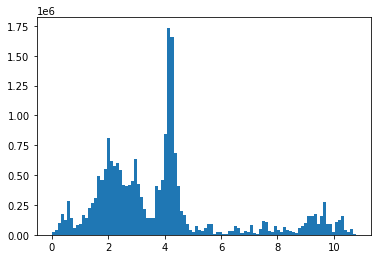

In [17]:
plt.hist(pooled_ad0.X.flatten(), 100);

Distribution very multi-modal

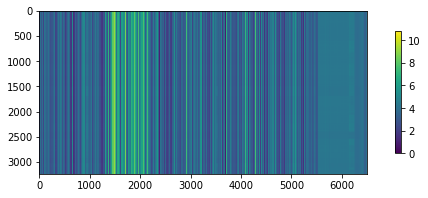

In [18]:
sk.set_figsize((10, 3))
plt.imshow(pooled_ad0.X)
plt.colorbar(shrink=0.75);

## Clustering by metabolic state: all clusters

In [19]:
pooled_ad1 = pooled_ad0.copy()

In [20]:
#log normalising
sc.pp.normalize_total(pooled_ad1, target_sum=1e4)
sc.pp.log1p(pooled_ad1)
pooled_ad1.raw = pooled_ad1

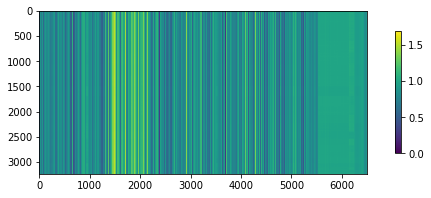

In [21]:
sk.set_figsize((10, 3))
plt.imshow(pooled_ad1.X)
plt.colorbar(shrink=0.75);

In [22]:
pooled_ad1.raw.X.sum(axis=1).min(), pooled_ad1.raw.X.sum(axis=1).max()

(5634.0664, 5678.153)

### highly variable features only

In [23]:
sc.pp.highly_variable_genes(pooled_ad1, subset=False)

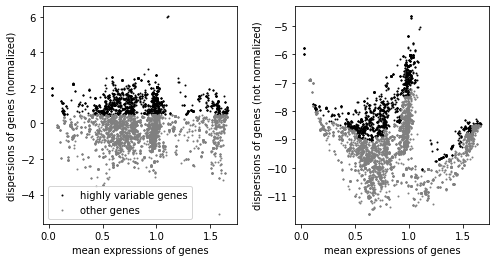

In [24]:
sk.set_figsize((4, 4))
sc.pl.highly_variable_genes(pooled_ad1)

In [25]:
sc.pp.scale(pooled_ad1, zero_center=True, max_value=10)

In [26]:
pooled_ad1a = pooled_ad1.copy()
sc.pp.pca(pooled_ad1a, use_highly_variable=True)
sc.pp.neighbors(pooled_ad1a, n_neighbors=10, n_pcs=14)
sc.tl.umap(pooled_ad1a, min_dist=0.1)

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


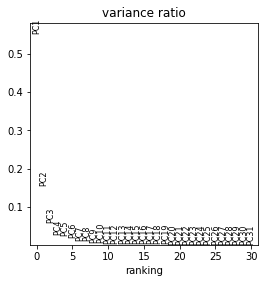

In [27]:
sc.pl.pca_variance_ratio(pooled_ad1a)

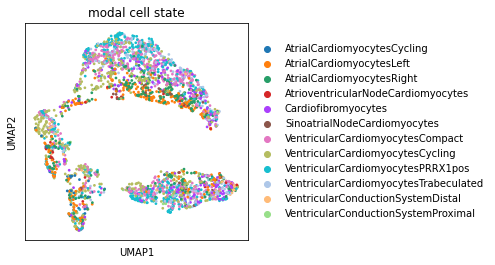

In [28]:
sc.pl.umap(pooled_ad1a, color=["modal cell state"], wspace=0.4, size=30)

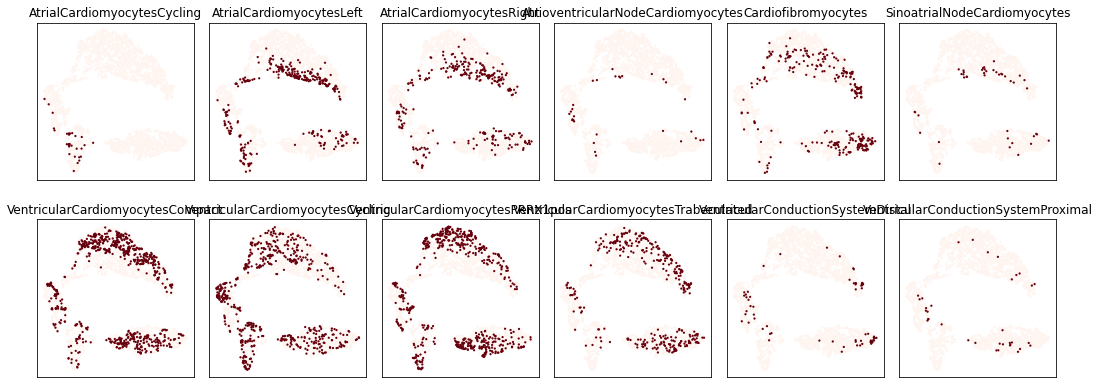

In [29]:
sk.highlight(
    pooled_ad1a, basis="umap", groupby="modal cell state", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [30]:
sc.tl.leiden(pooled_ad1a, resolution=0.1, key_added="leiden_0p1")

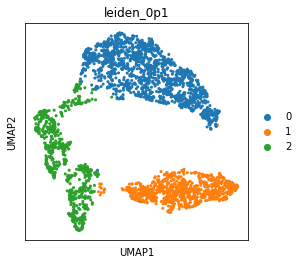

In [31]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad1a, color=["leiden_0p1"])

In [32]:
sc.tl.rank_genes_groups(pooled_ad1a, groupby="leiden_0p1", method="wilcoxon")

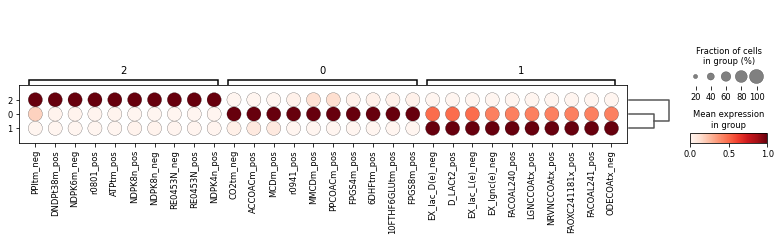

In [33]:
sc.pl.rank_genes_groups_dotplot(pooled_ad1a, groupby="leiden_0p1", standard_scale="var")

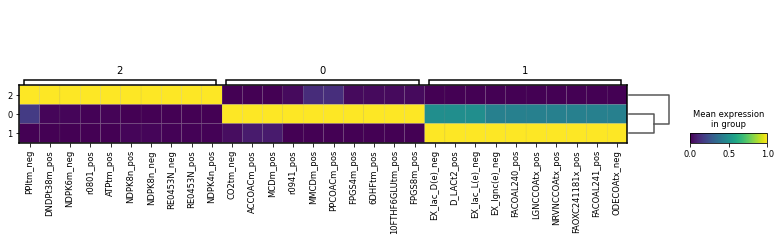

In [34]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad1a, groupby="leiden_0p1", standard_scale="var")

### all features

In [35]:
pooled_ad1b = pooled_ad1.copy()
sc.pp.pca(pooled_ad1b, use_highly_variable=False)
sc.pp.neighbors(pooled_ad1b, n_neighbors=20, n_pcs=10)
sc.tl.umap(pooled_ad1b, min_dist=0.1)

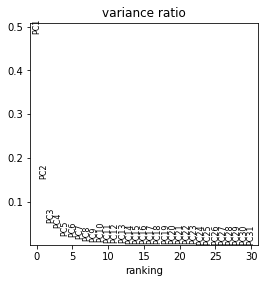

In [36]:
sc.pl.pca_variance_ratio(pooled_ad1b)

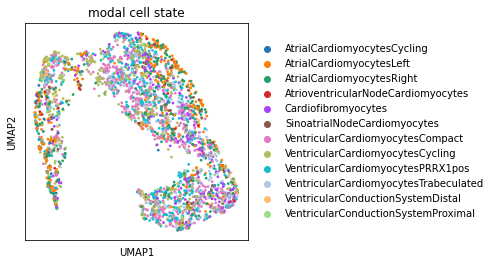

In [37]:
sc.pl.umap(pooled_ad1b, color=["modal cell state"], wspace=0.4, size=30)

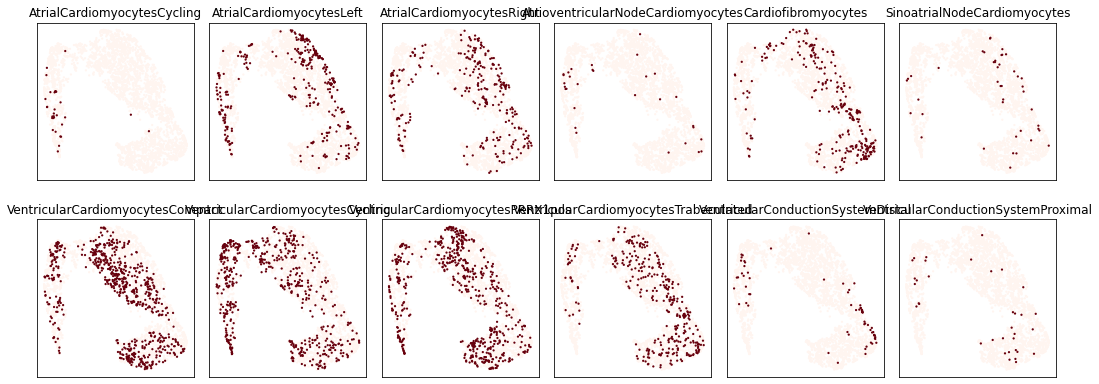

In [39]:
sk.highlight(
    pooled_ad1b, basis="umap", groupby="modal cell state", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [40]:
sc.tl.leiden(pooled_ad1b, resolution=0.1, key_added="leiden_0p1")

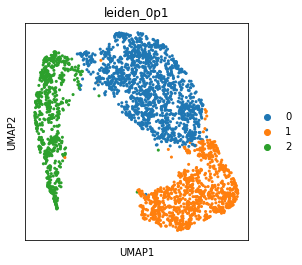

In [41]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad1b, color=["leiden_0p1"])

In [42]:
sc.tl.rank_genes_groups(pooled_ad1b, groupby="leiden_0p1", method="wilcoxon")

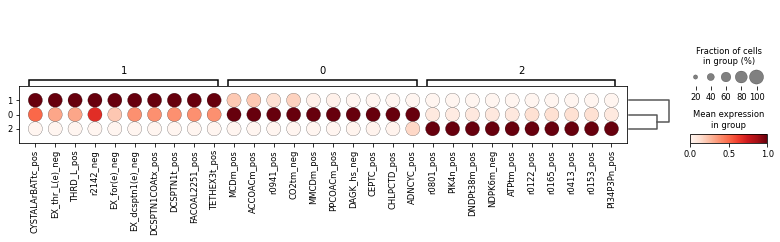

In [43]:
sc.pl.rank_genes_groups_dotplot(pooled_ad1b, groupby="leiden_0p1", standard_scale="var")

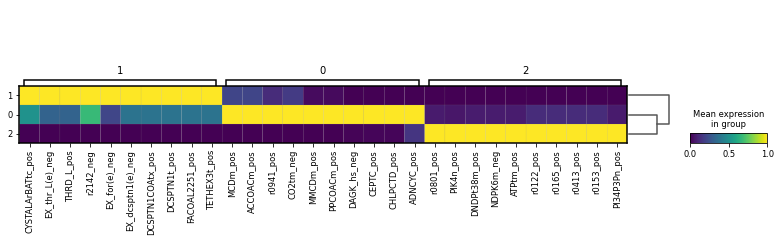

In [44]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad1b, groupby="leiden_0p1", standard_scale="var")

## Clustering by metabolic state: only cell-state specific clusters

In [45]:
pooled_ad2 = pooled_ad0.copy()
print(pooled_ad2.shape)
pooled_ad2 = pooled_ad2[pooled_ad2.obs['percentage']>0.9] # keep only clusters where 90% of cells are of one cell state
print(pooled_ad2.shape)

(3237, 6508)
(1090, 6508)


In [46]:
#log normalising
sc.pp.normalize_total(pooled_ad2, target_sum=1e4)
sc.pp.log1p(pooled_ad2)
pooled_ad2.raw = pooled_ad2

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


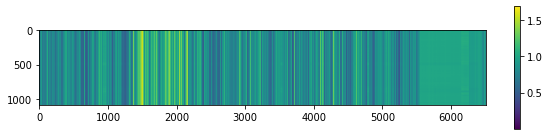

In [47]:
sk.set_figsize((10, 3))
plt.imshow(pooled_ad2.X)
plt.colorbar(shrink=0.75);

In [48]:
pooled_ad2.raw.X.sum(axis=1).min(), pooled_ad2.raw.X.sum(axis=1).max()

(5635.426, 5678.153)

### highly variable features only

In [49]:
sc.pp.highly_variable_genes(pooled_ad2, subset=False)

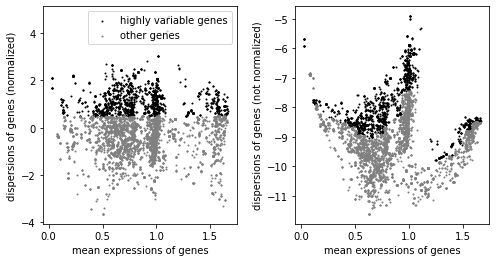

In [50]:
sk.set_figsize((4, 4))
sc.pl.highly_variable_genes(pooled_ad2)

In [51]:
sc.pp.scale(pooled_ad2, zero_center=True, max_value=10)

In [52]:
pooled_ad2a = pooled_ad2.copy()
sc.pp.pca(pooled_ad2a, use_highly_variable=True)
sc.pp.neighbors(pooled_ad2a, n_neighbors=10, n_pcs=14)
sc.tl.umap(pooled_ad2a, min_dist=0.1)

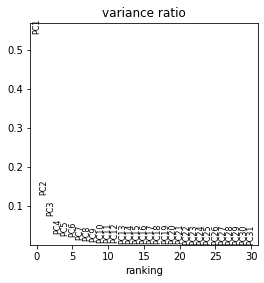

In [53]:
sc.pl.pca_variance_ratio(pooled_ad2a)

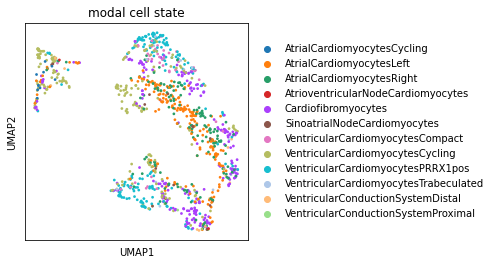

In [54]:
sc.pl.umap(pooled_ad2a, color=["modal cell state"], wspace=0.4, size=30)

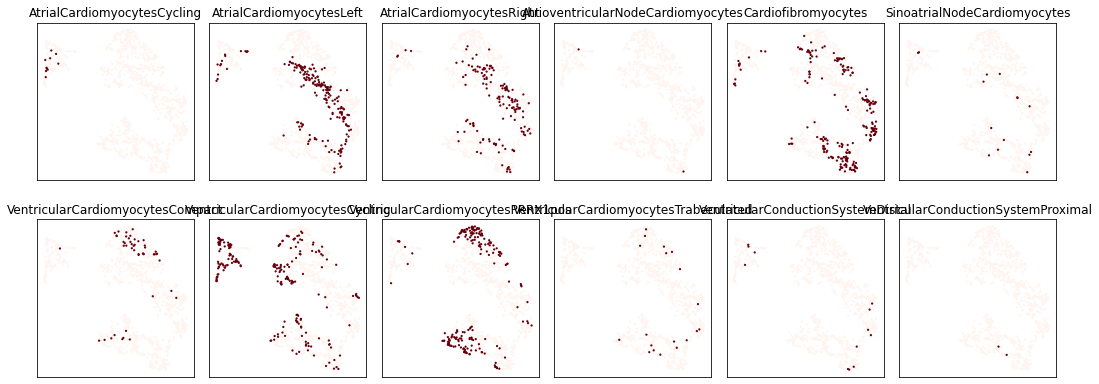

In [55]:
sk.highlight(
    pooled_ad2a, basis="umap", groupby="modal cell state", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [58]:
sc.tl.leiden(pooled_ad2a, resolution=0.1, key_added="leiden_0p1")

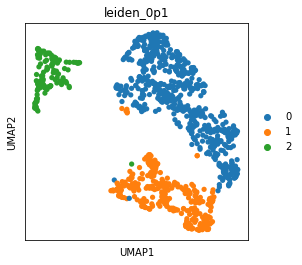

In [59]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad2a, color=["leiden_0p1"])

In [60]:
sc.tl.rank_genes_groups(pooled_ad2a, groupby="leiden_0p1", method="wilcoxon")

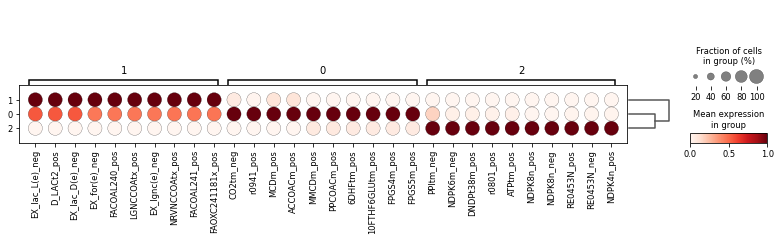

In [61]:
sc.pl.rank_genes_groups_dotplot(pooled_ad2a, groupby="leiden_0p1", standard_scale="var")

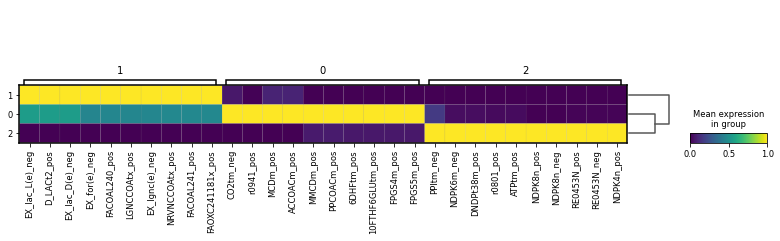

In [62]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad2a, groupby="leiden_0p1", standard_scale="var")

[]

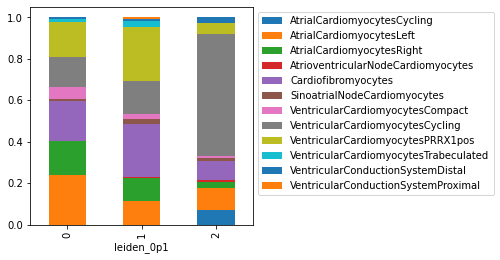

In [63]:
tmp = pd.crosstab(pooled_ad2a.obs['leiden_0p1'], pooled_ad2a.obs['modal cell state'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

### all features

In [64]:
pooled_ad2b = pooled_ad2.copy()
sc.pp.pca(pooled_ad2b, use_highly_variable=False)
sc.pp.neighbors(pooled_ad2b, n_neighbors=20, n_pcs=10)
sc.tl.umap(pooled_ad2b, min_dist=0.1)

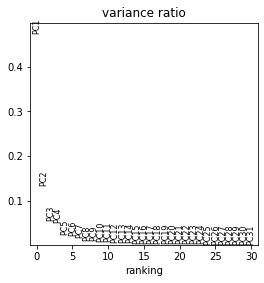

In [65]:
sc.pl.pca_variance_ratio(pooled_ad2b)

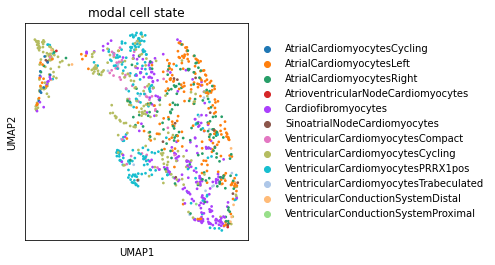

In [66]:
sc.pl.umap(pooled_ad2b, color=["modal cell state"], wspace=0.4, size=30)

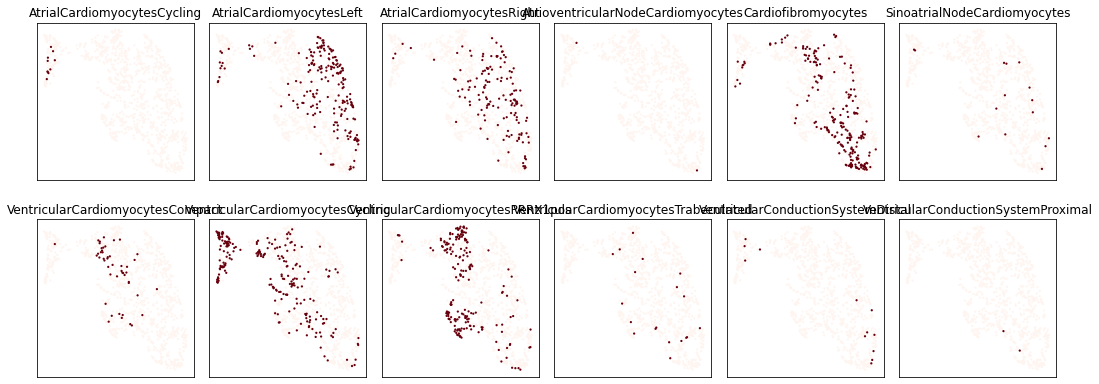

In [67]:
sk.highlight(
    pooled_ad2b, basis="umap", groupby="modal cell state", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [68]:
sc.tl.leiden(pooled_ad2b, resolution=0.1, key_added="leiden_0p1")

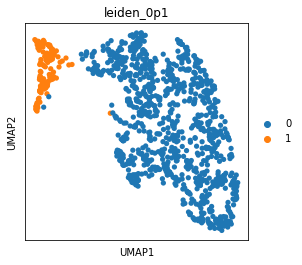

In [69]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad2b, color=["leiden_0p1"])

In [70]:
sc.tl.rank_genes_groups(pooled_ad2b, groupby="leiden_0p1", method="wilcoxon")

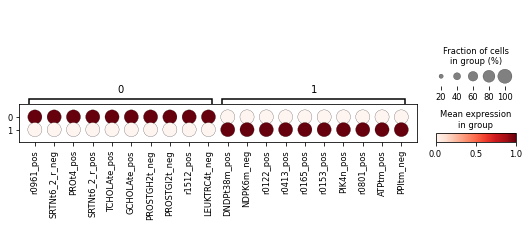

In [71]:
sc.pl.rank_genes_groups_dotplot(pooled_ad2b, groupby="leiden_0p1", standard_scale="var")

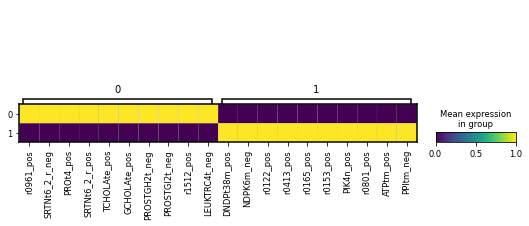

In [72]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad2b, groupby="leiden_0p1", standard_scale="var")

[]

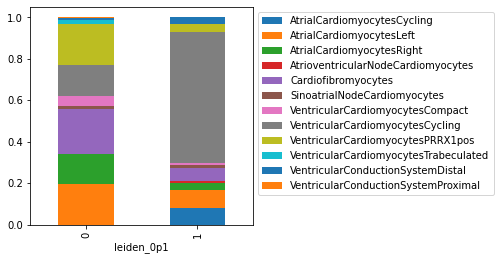

In [73]:
tmp = pd.crosstab(pooled_ad2b.obs['leiden_0p1'], pooled_ad2b.obs['modal cell state'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

## Clustering by metabolic state: only cell-state specific clusters, with cycling cells removed

In [76]:
pooled_ad3 = pooled_ad0.copy()
print(pooled_ad3.shape)
pooled_ad3 = pooled_ad3[pooled_ad3.obs['percentage']>0.9] # keep only clusters where 90% of cells are of one cell state
print(pooled_ad3.shape)
pooled_ad3 = pooled_ad3[pooled_ad3.obs['modal cell state']!='AtrialCardiomyocytesCycling'] # keep only clusters where 90% of cells are of one cell state
print(pooled_ad3.shape)
pooled_ad3 = pooled_ad3[pooled_ad3.obs['modal cell state']!='VentricularCardiomyocytesCycling'] # keep only clusters where 90% of cells are of one cell state
print(pooled_ad3.shape)

(3237, 6508)
(1090, 6508)
(1080, 6508)
(855, 6508)


In [77]:
#log normalising
sc.pp.normalize_total(pooled_ad3, target_sum=1e4)
sc.pp.log1p(pooled_ad3)
pooled_ad3.raw = pooled_ad3

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


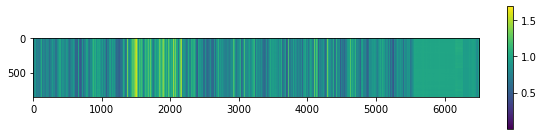

In [78]:
sk.set_figsize((10, 3))
plt.imshow(pooled_ad3.X)
plt.colorbar(shrink=0.75);

In [79]:
pooled_ad3.raw.X.sum(axis=1).min(), pooled_ad3.raw.X.sum(axis=1).max()

(5636.471, 5672.1787)

### highly variable features only

In [80]:
sc.pp.highly_variable_genes(pooled_ad3, subset=False)

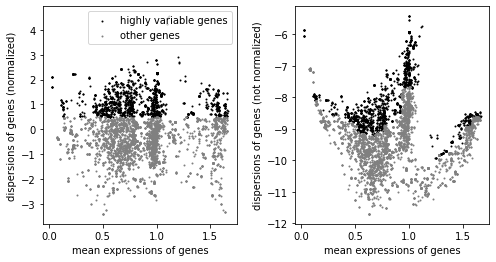

In [81]:
sk.set_figsize((4, 4))
sc.pl.highly_variable_genes(pooled_ad3)

In [82]:
sc.pp.scale(pooled_ad3, zero_center=True, max_value=10)

In [83]:
pooled_ad3a = pooled_ad3.copy()
sc.pp.pca(pooled_ad3a, use_highly_variable=True)
sc.pp.neighbors(pooled_ad3a, n_neighbors=10, n_pcs=14)
sc.tl.umap(pooled_ad3a, min_dist=0.1)

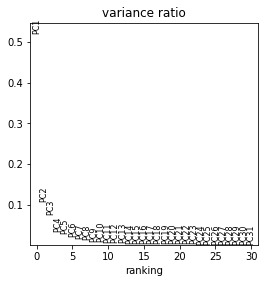

In [84]:
sc.pl.pca_variance_ratio(pooled_ad3a)

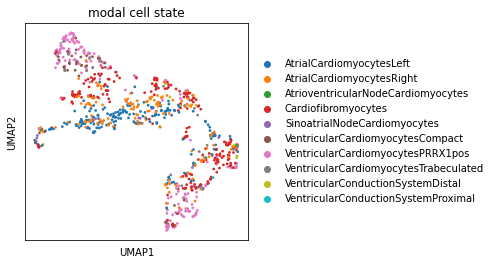

In [85]:
sc.pl.umap(pooled_ad3a, color=["modal cell state"], wspace=0.4, size=30)

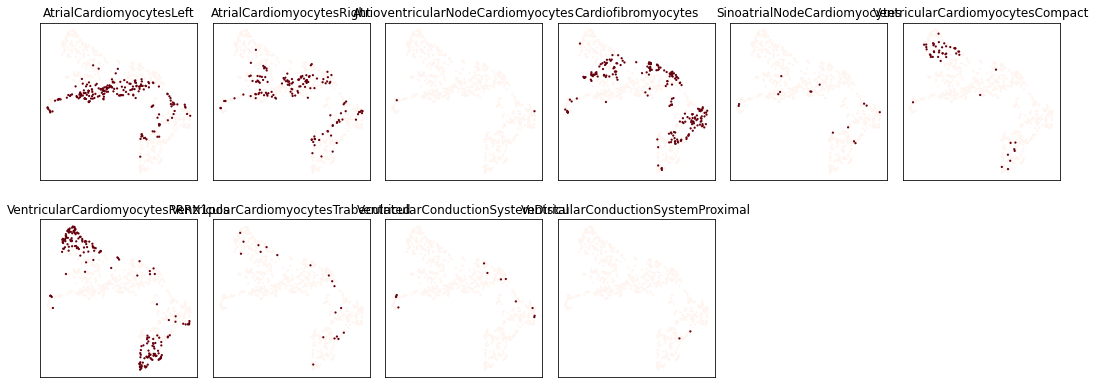

In [86]:
sk.highlight(
    pooled_ad3a, basis="umap", groupby="modal cell state", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [101]:
sc.tl.leiden(pooled_ad3a, resolution=0.5, key_added="leiden_0p5")

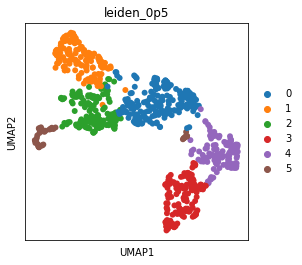

In [102]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad3a, color=["leiden_0p5"])

In [103]:
sc.tl.rank_genes_groups(pooled_ad3a, groupby="leiden_0p5", method="wilcoxon")

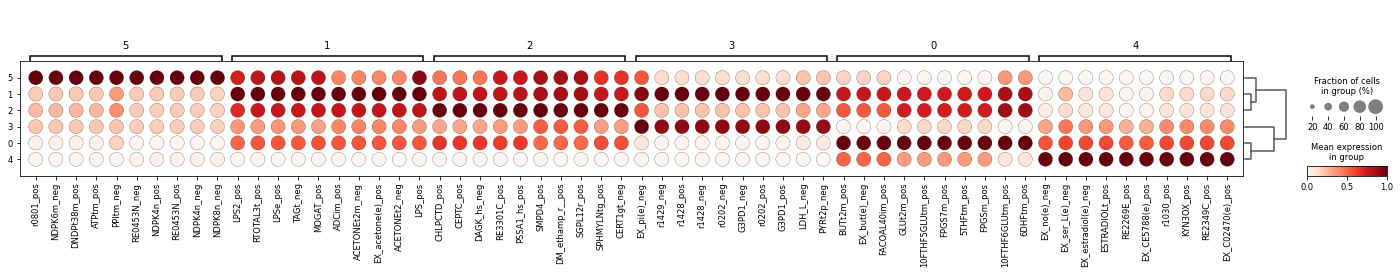

In [104]:
sc.pl.rank_genes_groups_dotplot(pooled_ad3a, groupby="leiden_0p5", standard_scale="var")

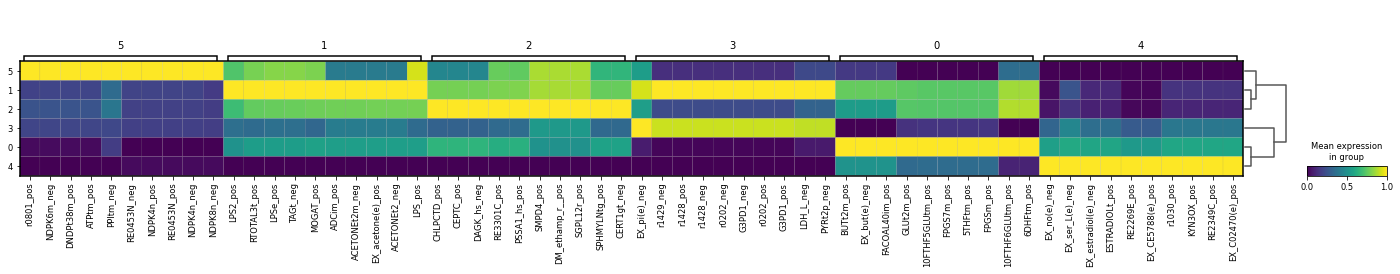

In [105]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad3a, groupby="leiden_0p5", standard_scale="var")

[]

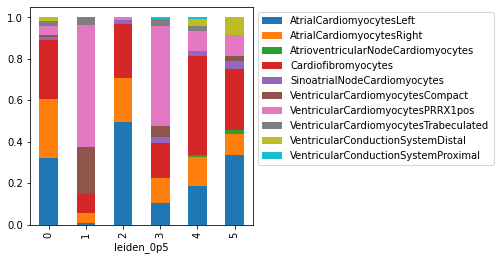

In [106]:
tmp = pd.crosstab(pooled_ad3a.obs['leiden_0p5'], pooled_ad3a.obs['modal cell state'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

### all features

In [107]:
pooled_ad3b = pooled_ad3.copy()
sc.pp.pca(pooled_ad3b, use_highly_variable=False)
sc.pp.neighbors(pooled_ad3b, n_neighbors=20, n_pcs=10)
sc.tl.umap(pooled_ad3b, min_dist=0.1)

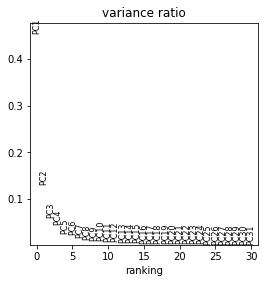

In [108]:
sc.pl.pca_variance_ratio(pooled_ad3b)

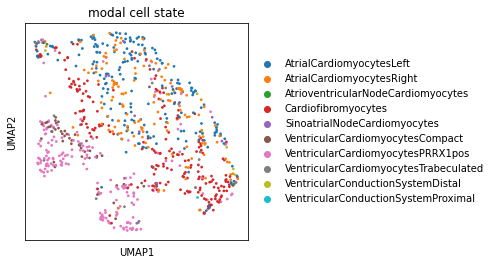

In [109]:
sc.pl.umap(pooled_ad3b, color=["modal cell state"], wspace=0.4, size=30)

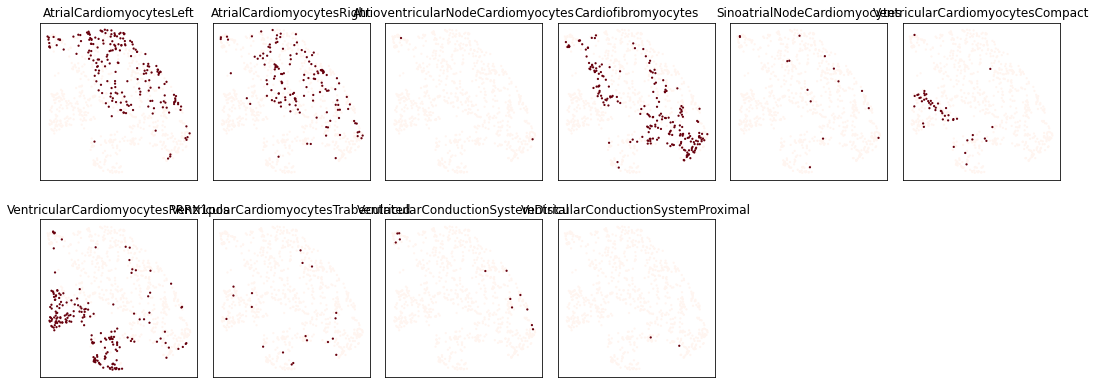

In [110]:
sk.highlight(
    pooled_ad3b, basis="umap", groupby="modal cell state", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [113]:
sc.tl.leiden(pooled_ad3b, resolution=0.3, key_added="leiden_0p3")

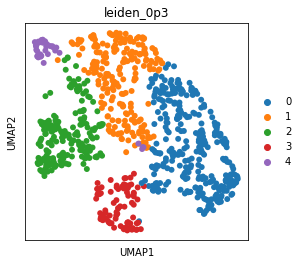

In [114]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad3b, color=["leiden_0p3"])

In [115]:
sc.tl.rank_genes_groups(pooled_ad3b, groupby="leiden_0p3", method="wilcoxon")

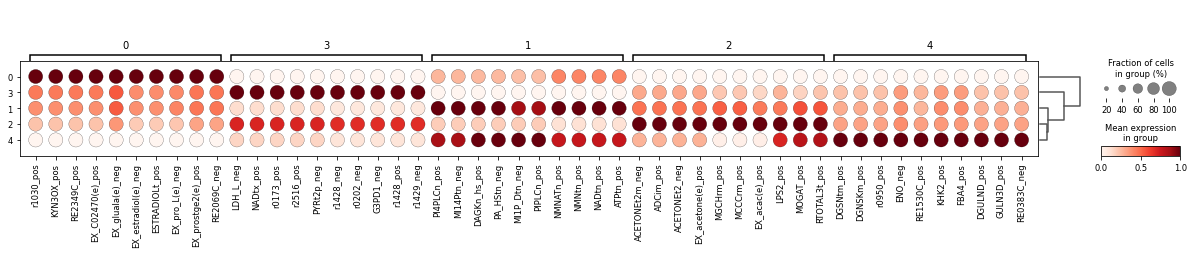

In [116]:
sc.pl.rank_genes_groups_dotplot(pooled_ad3b, groupby="leiden_0p3", standard_scale="var")

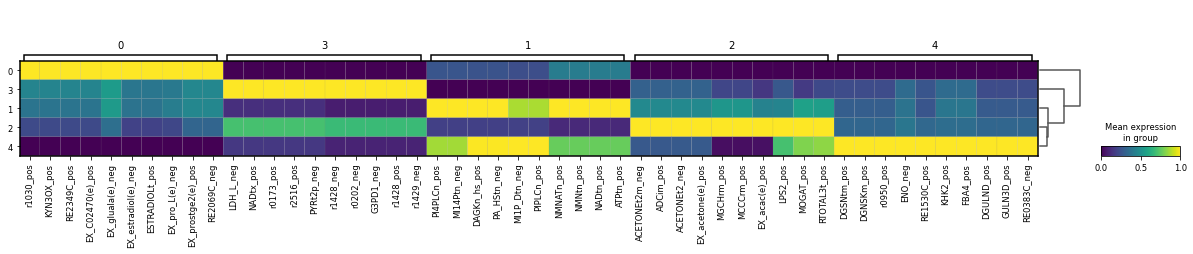

In [117]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad3b, groupby="leiden_0p3", standard_scale="var")

[]

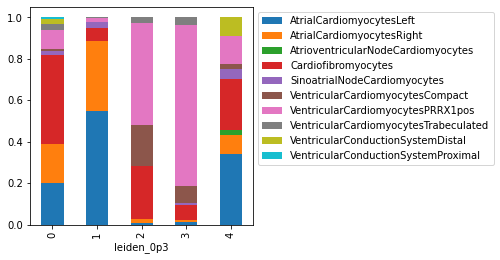

In [118]:
tmp = pd.crosstab(pooled_ad3b.obs['leiden_0p3'], pooled_ad3b.obs['modal cell state'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

# Save object

In [83]:
pooled_ad1a

AnnData object with n_obs × n_vars = 2680 × 6493
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'cluster_id', 'group_donor', 'DonorID', 'PatientGroup', 'celltype', 'amanda_annot', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_top50', 'leiden_0p3'
    var: 'reaction_name', 'formula', 'associated_genes', 'subsystem', 'EC_number', 'confidence', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0p3_colors', 'rank_genes_groups', 'dendrogram_leiden_0p3'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [85]:
pooled_ad1a.write("asthma_metabolome.compass.converted_in_pool.hvg_umap.20220620.h5ad", compression="gzip")

In [84]:
pooled_ad1b

AnnData object with n_obs × n_vars = 2680 × 6493
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'cluster_id', 'group_donor', 'DonorID', 'PatientGroup', 'celltype', 'amanda_annot', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_top50', 'leiden_0p3'
    var: 'reaction_name', 'formula', 'associated_genes', 'subsystem', 'EC_number', 'confidence', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0p3_colors', 'rank_genes_groups', 'dendrogram_leiden_0p3'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [86]:
pooled_ad1b.write("asthma_metabolome.compass.converted_in_pool.all_umap.20220620.h5ad", compression="gzip")